## Classification - Part 3: Imbalanced Data (Neural Network)
- Objective : 
    1. Classify yes class  along with their probability.

## 1.0 Constrains

### 1.1 Modeling Constraints : 
- Modeling Type : Classification    
- Model Explainaibility : 
    - 1. One Logistic Regression Model : Explainable Model
    - 2. Another Black Box Model : 
        
    
### 1.2 Data Constraint :
- Primary Data : 
    - Dependent / Outcome Variable :  y (0/1)
    - Independent / Predictor Variables :  100 Feature Variables (Categorical, numerical)
- Imbalanced Data :  


### 1.3 Evaluation Metrics Constraint:
- Imbalanced Data specific Evaluation Metrics
- General constraints i.e accuracy leads to improper evaluation / modeling & final choice.

### 1.4 Framework Constraint : 
- This constraint is self-selected based on ease of use and data size.
- Scikit-learn. 
    - Scikit-Learn : Given that the Data-size is comparatively small, scikit-learn  is selected as the framework, given its comparative ease  or use and faster Iteration possiblity.
- TensorFlow/ Keras : Complex Deep Neural Network  modeling and GPU support is provided by TensorFlow / Keras, and hence is used for more complex NN modeling.
- StatsModel :
    - Scikit-learn provides more varied models(Forest, Boosting, Bagging, SVM, NNs), powerful parameter customisation and control. However the LR model generated by them have few model and model parameter statistics compared to StatsModel (i.e p-value, 95% CI, marginal_effects ). Hence we will use StatsModel's LogisticRegression in the second part.



## 1. Data Load: Modeling Ready Data
- Data has been preprocessed with the earlier notebook.
- We are loading the preprocessed data in this step.

In [33]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

test_df = pd.read_csv("Data/ModelReadyData/test_df.csv")
train_df = pd.read_csv("Data/ModelReadyData/train_df.csv")

X_train = pd.read_csv("Data/ModelReadyData/X_train.csv")
y_train = pd.read_csv("Data/ModelReadyData/y_train.csv", index_col=False)

X_valid = pd.read_csv("Data/ModelReadyData/X_valid.csv")
y_valid = pd.read_csv("Data/ModelReadyData/y_valid.csv")

# X_train_smote = pd.read_csv("Data/ModelReadyData/X_train_smote.csv")
# y_train_smote = pd.read_csv("Data/ModelReadyData/y_train_smote.csv")

# ckpt_train_df_pre_scaling = pd.read_csv("Data/ModelReadyData/ckpt_train_df_pre_scaling.csv")

### 4.2 Evaluation Metric Selection:

- Accuracy is a bad Evaluation metric given  highly imbalanced nature of Data.
- We will choose AUC, recall, F1-score and additionally use confusion matrix. 
- Recall : Ability of model to find all positive classes
- Precision : Ability of model to not label as positive a sample that is negative.
- Balanced accuracy : avg of recall across all classes.


In [21]:
from sklearn.model_selection import cross_validate

scoring = ["roc_auc", "recall", "precision", "accuracy", "balanced_accuracy", "f1"]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from typing import List
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn import tree
from sklearn.model_selection import cross_validate


# Defining the confusion matrix function
def plot_confusion_matrix(cm, class_labels, title="Confusion matrix", cmap=plt.cm.Blues):
    import itertools

    plt.figure(figsize=(3, 3))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


def area_under_roc(y, pred):
    from sklearn import metrics

    # fpr,tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2 )
    auc = metrics.roc_auc_score(y, pred)
    # print('fpr,tpr, AUC (higher is better)', fpr, tpr, auc)
    print("AUC (higher is better)", auc)
    return auc


def eval_classification(
    y_test,
    ypred_test,
    class_labels=["Retained", "Churn - Lost"],
    title="Confusion Matrix",
    metrics=["confusion_matrix"],
):
    returned_metrics = []

    if "auc" in metrics:
        auc = area_under_roc(y_test, ypred_test)
        returned_metrics.append(auc)
    if "confusion_matrix" in metrics:
        print("Confusion report is")
        print(classification_report(y_test, ypred_test))
        conf_matrix = confusion_matrix(y_test, ypred_test)
        plot_confusion_matrix(conf_matrix, class_labels=class_labels, title=title)
        returned_metrics.append(conf_matrix)

    return returned_metrics[0] if len(returned_metrics) == 1 else returned_metrics


def plot_roc(y_test: List[int], y_test_proba: List[float]):
    auc = roc_auc_score(y_test, y_test_proba)
    print("Logistic: ROC AUC=%.3f" % (auc))

    # # keep probabilities for the positive outcome only
    # probability_positive_class = y_test_proba[:, 1]
    probability_positive_class = y_test_proba

    fpr, tpr, _ = roc_curve(y_test, probability_positive_class)

    pyplot.plot(fpr, tpr, marker=".", label="")
    pyplot.title("ROC Curve")
    pyplot.xlabel("False Positive Rate (False Alarm Rate)")
    pyplot.ylabel("True Positive Rate ( Sensitivity, Hit Rate)")
    pyplot.legend()
    pyplot.show()


def plot_roc_for_binary_prediction_label(y_test, y_test_prediction):
    from plot_metric.functions import BinaryClassification

    bc = BinaryClassification(y_test, y_test_prediction, labels=["Class 1", "Class 2"])
    # Figures
    plt.figure(figsize=(5, 5))
    bc.plot_roc_curve()
    plt.show()


def create_new_score_tracker_df(scoring):
    score_tracker_dict = {"model_name": []}
    scores = {}
    for cur_scoring in scoring:
        score_tracker_dict.update({cur_scoring: []})

    score_tracker_df = pd.DataFrame(score_tracker_dict)
    return score_tracker_df


def add_cv_score_to_df(df, model_descriptor_name, scoring, cur_clf_cv_result):
    cur_scores = {"model_name": model_descriptor_name}
    for cur_scoring in scoring:
        cur_scores.update({cur_scoring: round(cur_clf_cv_result["test_" + cur_scoring].mean(), 2)})

    df = df.append(cur_scores, ignore_index=True)
    df = df.drop_duplicates(keep="last")
    return df


def get_cv_scores(clf, model_descriptor_name, X, y, scoring, score_tracker_df=None, cv_fold=5):
    # Create Score tracker df if first run
    if score_tracker_df is None:
        print("Created New Score Tracker")
        score_tracker_df = create_new_score_tracker_df(scoring)

    cur_clf_cv_result = cross_validate(clf, X, y, cv=cv_fold, scoring=scoring)
    score_tracker_df = add_cv_score_to_df(score_tracker_df, model_descriptor_name, scoring, cur_clf_cv_result)

    return score_tracker_df


def get_benchmark_cv_scores(clf, x_columns, df, model_name, score_tracker_df=None):
    if x_columns is None:
        x_columns = list(df.columns)
        x_columns.remove("y")
    print(f" Columns : {len(x_columns)}")
    cur_X_train, cur_y_train, _, _ = get_stratified_data(df[x_columns], df["y"], test_size=0.01, seed=4)
    score_tracker_df = get_cv_scores(
        clf=clf,
        X=cur_X_train,
        y=cur_y_train[0],
        cv_fold=5,
        scoring=scoring,
        model_descriptor_name=model_name,
        score_tracker_df=score_tracker_df,
    )
    return score_tracker_df


def get_clasifier_evaluation(clf, X_train=None, y_train=None, X_valid=None, y_valid=None):
    clf.fit(X_train, y_train)
    y_pred_valid = clf.predict(X_valid)
    eval_classification(y_valid, y_pred_valid, class_labels=["no", "yes"], metrics=["auc", "confusion_matrix"])

## DataSet Creation
def get_stratified_data(X_df, y_series, test_size=0.2, verbose=False, seed=4):
    from sklearn.model_selection import StratifiedShuffleSplit

    feature_cols = list(X_df.columns)
    # target_col = y_df.columns

    X = np.array(X_df)
    y = np.array(y_series)

    sss = StratifiedShuffleSplit(n_splits=2, test_size=test_size, random_state=seed)
    sss.get_n_splits(X, y)

    for train_index, test_index in sss.split(X, y):
        if verbose:
            print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    X_train = pd.DataFrame(X_train, columns=feature_cols)
    X_test = pd.DataFrame(X_test, columns=feature_cols)

    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)

    if verbose:
        print(f"\n ...No. of Training Data : {len(X_train)}")
        print(f" ...No. of Test Data     : {len(X_test)}")
        print(f" ...No. of Features : {len(X_train.columns)}")
        print(f" ...Train Bincount : {np.bincount(y_train[0])}")
        print(f" ...Test Bincount  : {np.bincount(y_test[0])}")

    return X_train, y_train, X_test, y_test

def simple_tree(
    X_trainR,
    y_trainR,
    X_testR,
    y_testR,
    max_depth=None,
    class_weight=None,
    class_labels=["yes", "no"],
    metrics=["confusion_matrix"],
):
    from sklearn import tree

    clf = tree.DecisionTreeClassifier(max_depth=max_depth, class_weight=class_weight)
    clf.fit(X_trainR, y_trainR)
    ypred_testR = clf.predict(X_testR)

    eval_classification(y_testR, ypred_testR, class_labels=class_labels, metrics=metrics)
    return clf


#### 4.4 Logistic Regression Modeling
- Params :
    - Smaller C ~ stronger regularisation like in SVM / SVC.



In [22]:
lr_clf = LogisticRegression(penalty="l2", C=0.01, class_weight="balanced")
score_tracker_df = get_benchmark_cv_scores(lr_clf, None, train_df, "LR-l2-0.01", None)

lr_clf = LogisticRegression(penalty="l2", C=1.01, class_weight="balanced")
score_tracker_df = get_benchmark_cv_scores(lr_clf, None, train_df, "LR-l2-1", score_tracker_df)

lr_clf = LogisticRegression(penalty="l1", solver="saga", C=0.1, class_weight="balanced")
score_tracker_df = get_benchmark_cv_scores(lr_clf, None, train_df, "LR-l1-0.1", score_tracker_df)

# lr_clf = LogisticRegression(penalty="l2", solver="liblinear", C=0.001, class_weight="balanced")
lr_clf = LogisticRegression(penalty="l1", solver="saga", C=0.1, class_weight="balanced")
score_tracker_df = get_benchmark_cv_scores(lr_clf, None, train_df, "LR-l1-0.1-SMOTE", score_tracker_df)


score_tracker_df


 Columns : 172
Created New Score Tracker


/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_470879/3729648702.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(cur_scores, ignore_index=True)


 Columns : 172


/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_470879/3729648702.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(cur_scores, ignore_index=True)


 Columns : 172


/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/tmp/ipykernel_470879/37296487

 Columns : 172


/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/tmp/ipykernel_470879/37296487

,model_name,roc_auc,recall,precision,accuracy,balanced_accuracy,f1
0,LR-l2-0.01,0.72,0.68,0.25,0.65,0.66,0.36
1,LR-l2-1,0.72,0.68,0.24,0.65,0.66,0.36
2,LR-l1-0.1,0.59,0.28,0.20,0.71,0.53,0.19
3,LR-l1-0.1-SMOTE,0.59,0.28,0.20,0.71,0.53,0.19


In [24]:
score_tracker_df.to_csv("Data/Output/score_tracker_Logistic_Regression.csv")

/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AUC (higher is better) 0.6970708981610888
Confusion report is
              precision    recall  f1-score   support

           0       0.93      0.68      0.79      6839
           1       0.28      0.71      0.40      1161

    accuracy                           0.69      8000
   macro avg       0.60      0.70      0.59      8000
weighted avg       0.84      0.69      0.73      8000



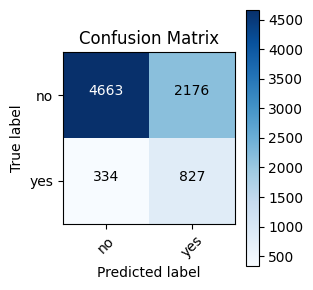

In [26]:
get_clasifier_evaluation(lr_clf, X_train, y_train, X_valid, y_valid)

#### 4.4.1 Logistic Regression: Test Prediction 
- We will now train on the full dataset rather than on train set only.  Then we will make final  probability prediction on X_test and write it to a file

In [34]:
# glmresults
def write_yes_probability_to_a_file(predict_probability, file_name):
    class_1_probability_df = pd.DataFrame(columns=["class_1_probability"])

    for i, class_proba in enumerate(predict_probability):
        _, one_proba = class_proba[0], class_proba[1]
        class_1_probability_df.loc[i] = round(one_proba, 4)

    class_1_probability_df.to_csv(file_name, header=None, index=None)
    return class_1_probability_df


feature_columns = list(train_df.columns)
feature_columns.remove("y")
X_all = train_df[feature_columns]
y_all = train_df["y"]

lr_clf = LogisticRegression(penalty="l1", solver="saga", C=0.1, class_weight="balanced")
lr_clf.fit(X_all, y_all)
y_test_predicted = lr_clf.predict_proba(test_df)

write_yes_probability_to_a_file(y_test_predicted, "Data/glmresults.csv")


/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,class_1_probability
0,0.1407
1,0.2721
2,0.6457
3,0.4622
4,0.0736
...,...
9995,0.1276
9996,0.6044
9997,0.4748
9998,0.6324


#### 4.5 Deep Neural Networks Modeling
- We will use Keras here because Sklearn only provides a single layer simple NN and more importantly it lacks GPU support. Both of which are addressed by Keras.
- Class Weights : 
    - Because we have highly imbalanced data, we will use class_weights 
-  Training Data :
    

In [ ]:
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history["loss"], label="Train " + label)
    plt.semilogy(history.epoch, history.history["val_loss"], label="Val " + label, linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")


def plot_metrics(history, metrics=["loss", "recall", "precision"]):
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label="Train")
        plt.plot(history.epoch, history.history["val_" + metric], linestyle="--", label="Val")
        plt.xlabel("Epoch")
        plt.ylabel(name)
        plt.ylim([plt.ylim()[0] - 0.1, plt.ylim()[1]])
        plt.legend()
    plt.show()


def print_auc(train_history, at_epoch):
    print(f"Training AUC at epoch {at_epoch} :  {train_history.history['auc'][at_epoch]}")
    print(f"Validation AUC at epoch {at_epoch} :  {train_history.history['val_auc'][at_epoch]}")


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix @{:.2f}".format(p))
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()

    print("Legitimate TrueClass Detected (True Negatives): ", cm[0][0])
    print("Legitimate TrueClass Incorrectly Detected (False Positives): ", cm[0][1])
    print("Fraudulent TrueClass Missed (False Negatives): ", cm[1][0])
    print("Fraudulent TrueClass Detected (True Positives): ", cm[1][1])
    print("Total FalseClass: ", np.sum(cm[1]))


import sklearn


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100 * fp, 100 * tp, label=name, linewidth=2, **kwargs)
    plt.xlabel("False positives (False Alarm Rate) [%]")
    plt.ylabel("True positives ( Sensitivity, Hit Rate) [%]")
    plt.xlim([-0.5, 100])
    plt.ylim([0, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect("equal")


def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect("equal")


def plot_hist_of_predictions(train_features, train_labels, test_features, clf_model, batch_size=128):
    train_predictions = model_dnn.predict(train_features, batch_size=batch_size)
    test_predictions = model_dnn.predict(test_features, batch_size=batch_size)

    predictions_df = pd.DataFrame({"Prediction": train_predictions.ravel(), "Label": train_labels.ravel()})
    predictions_df = pd.concat(
        [
            predictions_df[predictions_df["Label"] == 0].sample(5000, random_state=0),
            predictions_df[predictions_df["Label"] == 1].sample(500, random_state=0),
        ]
    )
    import plotly.express as px

    fig = px.histogram(
        predictions_df,
        x="Prediction",
        title="Prediction values",
        color="Label",
        marginal="box",
        labels={"0": "NoClass", "1": "YesClass"},
    )
    fig.update_traces(opacity=0.75)
    fig.update_layout(barmode="overlay")
    fig.show()


Weight for class no: 0.58
Weight for class yes: 3.45
Output layer Bias for faster/ better convergence : [-1.77386368]
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                11008     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 

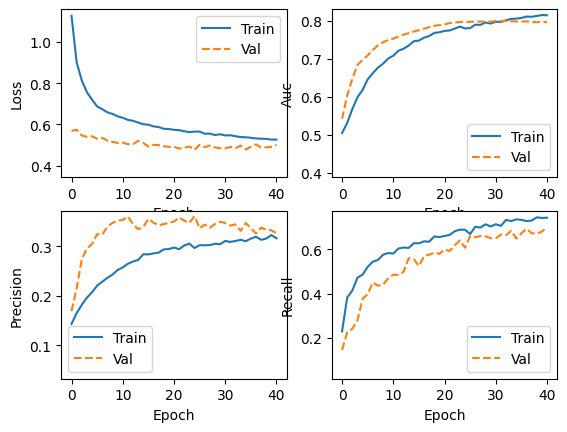

63/63 [==============================] - 0s 637us/step


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Recall, Precision, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import SquaredHinge, BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping


def create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=None):
    METRICS = [
        AUC(name="auc", from_logits=True),
        Recall(name="recall"),
        Precision(name="precision"),
        BinaryAccuracy(name="BinaryAccuracy"),  # Accuracy for True Class
        AUC(name="prc", curve="PR"),
    ]
    # For imbalanced Data, we want to add intial bias for better convergence at the output layer
    if output_layer_bias is not None:
        output_layer_bias = Constant(output_layer_bias)

    model = Sequential(
        [
            Dense(64, activation="relu", input_shape=(no_of_features,)),  # input_layer
            Dropout(0.5),
            Dense(128, activation="relu"),  # hidden_layer
            Dropout(0.5),
            Dense(1, activation="sigmoid", bias_initializer=output_layer_bias),  # output_layer
        ]
    )

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=METRICS)
    return model


# Transform DataFrame in Numpy array, as expected by Keras NN models down the line
X_train_np_arr = np.array(X_train)
y_train_np_arr = np.array(y_train)
X_valid_np_arr = np.array(X_valid)
y_valid_np_arr = np.array(y_valid)
X_train_smote_np_arr = np.array(X_train_smote)
y_train_smote_np_arr = np.array(y_train_smote)


##  Imbalanced Data Handling:
# Class Weight
no_of_features = X_train_np_arr.shape[-1]
yes_class_count = sum(y_train_np_arr)[0]
no_class_count = len(y_train_np_arr) - yes_class_count
total = no_class_count + yes_class_count
# total /2.0 to ensure losses for both classes get equal importance
weight_for_yes = (1 / yes_class_count) * (total / 2.0)
weight_for_no = (1 / no_class_count) * (total / 2.0)
class_weight = {0: weight_for_no, 1: weight_for_yes}
print("Weight for class no: {:.2f}".format(weight_for_no))
print("Weight for class yes: {:.2f}".format(weight_for_yes))
output_layer_bias = np.log([yes_class_count / no_class_count])
print(f"Output layer Bias for faster/ better convergence : {output_layer_bias}")


early_stopping = EarlyStopping(monitor="val_auc", verbose=1, patience=10, mode="max", restore_best_weights=True)


model_dnn = create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=output_layer_bias)
model_dnn.summary()
train_history = model_dnn.fit(
    X_train_np_arr,
    y_train_np_arr,
    validation_data=(X_valid_np_arr, y_valid_np_arr),
    batch_size=1024,
    epochs=500,
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=0,
)
y_valid_dnn_predicted = model_dnn.predict(X_valid_np_arr, batch_size=8024)
print_auc(train_history, 36)
plot_metrics(train_history, metrics=["loss", "auc", "precision", "recall"])
plot_hist_of_predictions(X_train_np_arr, y_train_np_arr, X_valid_np_arr, model_dnn)


In [ ]:
print_auc(train_history, 31)
# print_auc(train_history, 97)
# print_auc(train_history, 113)

Training AUC at epoch 31 :  0.7961822748184204
Validation AUC at epoch 31 :  0.7982476949691772


##### 4.5.1 DNN with smote
- Because we are using class_weights, smote is observed to have not much positive impact on the model performance improvement

Restoring model weights from the end of the best epoch: 66.
Epoch 76: early stopping
Training AUC at epoch 50 :  0.7951669096946716
Validation AUC at epoch 50 :  0.7849267721176147


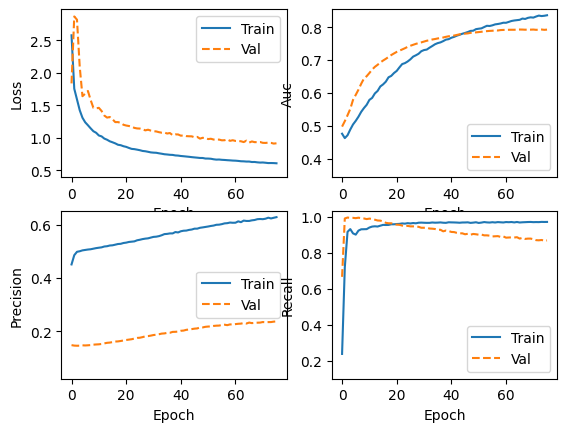

In [ ]:
model_smote = create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=output_layer_bias)
train_history_smote = model_smote.fit(X_train_smote_np_arr, y_train_smote_np_arr,          
          validation_data=(X_valid_np_arr, y_valid_np_arr),
          batch_size=8024, epochs=500, callbacks=[early_stopping], class_weight=class_weight,
          verbose=0
          )
print_auc(train_history_smote, 50)
plot_metrics(train_history_smote, metrics=['loss', 'auc', 'precision', 'recall'])

##### 4.5.2 DNN with Categorical Cross-entropy:
- We transformed the binary representation of (0/1) into dummy representation [0,1] and trained with categorical cross-entropy loss.

Weight for class no: 0.58
Weight for class yes: 3.45
Output layer Bias for faster/ better convergence : [-1.77386368]
Restoring model weights from the end of the best epoch: 543.
Epoch 593: early stopping


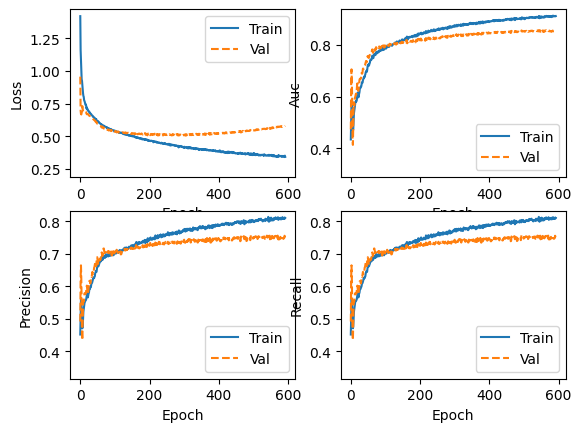

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Recall, Precision, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import (
    SquaredHinge,
    BinaryCrossentropy,
    SparseCategoricalCrossentropy,
    CategoricalCrossentropy,
)
from tensorflow.keras.callbacks import EarlyStopping


def create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=None):
    METRICS = [
        AUC(name="auc", from_logits=True),
        Recall(name="recall"),
        Precision(name="precision"),
        BinaryAccuracy(name="BinaryAccuracy"),  # Accuracy for True Class
    ]
    # For imbalanced Data, we want to add intial bias for better convergence at the output layer
    if output_layer_bias is not None:
        output_layer_bias = Constant(output_layer_bias)

    model = Sequential(
        [
            Dense(64, activation="relu", input_shape=(no_of_features,)),  # input_layer
            Dropout(0.5),
            Dense(128, activation="relu"),  # hidden_layer
            Dropout(0.5),
            Dense(2, activation="softmax", name="predictions", bias_initializer=output_layer_bias),  # output_layer
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        #   loss=BinaryCrossentropy(),
        loss=CategoricalCrossentropy(),
        metrics=METRICS,
    )
    return model


# Transform DataFrame in Numpy array, as expected by Keras NN models down the line
X_train_np_arr = np.array(X_train)
y_train_np_arr = np.array(y_train)
X_valid_np_arr = np.array(X_valid)
y_valid_np_arr = np.array(y_valid)
X_train_smote_np_arr = np.array(X_train_smote)
y_train_smote_np_arr = np.array(y_train_smote)
y_train_np_arr_cross_entropy = tf.one_hot(y_train_np_arr, depth=2)
y_valid_np_arr_cross_entropy = tf.one_hot(y_valid_np_arr, depth=2)
y_train_np_arr_cross_entropy = tf.reshape(y_train_np_arr_cross_entropy, [y_train_np_arr_cross_entropy.shape[0], 2])
y_valid_np_arr_cross_entropy = tf.reshape(y_valid_np_arr_cross_entropy, [y_valid_np_arr_cross_entropy.shape[0], 2])


##  Imbalanced Data Handling:
# Class Weight
yes_class_count = sum(y_train_np_arr)[0]
no_class_count = len(y_train_np_arr) - yes_class_count
total = no_class_count + yes_class_count
weight_for_yes = (1 / yes_class_count) * (total / 2.0) # total /2.0 to ensure losses for both classes get equal importance
weight_for_no = (1 / no_class_count) * (total / 2.0)
class_weight = {0: weight_for_no, 1: weight_for_yes}
print("Weight for class no: {:.2f}".format(weight_for_no))
print("Weight for class yes: {:.2f}".format(weight_for_yes))

output_layer_bias = np.log([yes_class_count / no_class_count])
print(f"Output layer Bias for faster/ better convergence : {output_layer_bias}")


early_stopping = EarlyStopping(monitor="val_auc", verbose=1, patience=50, mode="max", restore_best_weights=True)

no_of_features = X_train_np_arr.shape[-1]
model_dnn_cross_entropy = create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=output_layer_bias)
# model_dnn.summary()
train_history_cross_entropy = model_dnn_cross_entropy.fit(
    X_train_np_arr,
    y_train_np_arr_cross_entropy,
    validation_data=(X_valid_np_arr, y_valid_np_arr_cross_entropy),
    batch_size=8024,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=0,
)
plot_metrics(train_history_cross_entropy, metrics=["loss", "auc", "precision", "recall"])


In [ ]:
print_auc(train_history_cross_entropy, 40)
print_auc(train_history_cross_entropy, 100)
print_auc(train_history_cross_entropy, 150)
print_auc(train_history_cross_entropy, 200)
print_auc(train_history_cross_entropy, 300)
print_auc(train_history_cross_entropy, 479)

Training AUC at epoch 40 :  0.6763357520103455
Validation AUC at epoch 40 :  0.7207580208778381
Training AUC at epoch 100 :  0.7909448146820068
Validation AUC at epoch 100 :  0.7973334789276123
Training AUC at epoch 150 :  0.8180625438690186
Validation AUC at epoch 150 :  0.8116292357444763
Training AUC at epoch 200 :  0.8442750573158264
Validation AUC at epoch 200 :  0.8179750442504883
Training AUC at epoch 300 :  0.8768588304519653
Validation AUC at epoch 300 :  0.8394731283187866
Training AUC at epoch 479 :  0.9038078784942627
Validation AUC at epoch 479 :  0.8530420064926147


### 4.6 Final Model Selection :  Deep Neural Networks
- Based on the AUc score on the Evaluation Dataset, we selected two models
    - Model 1: Logistic Regression : 
            - Validation AUC  :  0.7
    - Model 2: NN(1 hidden layer with class weighting and output layer bias applied) - without SMOTE Data Balancing
        - AUC Score :  
            - Training AUC at epoch 479    :  0.91
            - Validation AUC at epoch 479 :  0.86

1/1 [==============================] - 0s 16ms/step


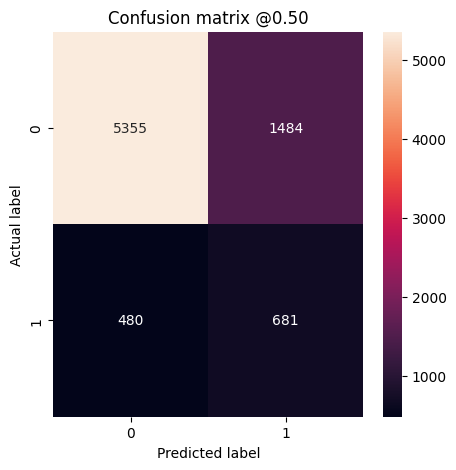

Legitimate TrueClass Detected (True Negatives):  5355
Legitimate TrueClass Incorrectly Detected (False Positives):  1484
Fraudulent TrueClass Missed (False Negatives):  480
Fraudulent TrueClass Detected (True Positives):  681
Total FalseClass:  1161


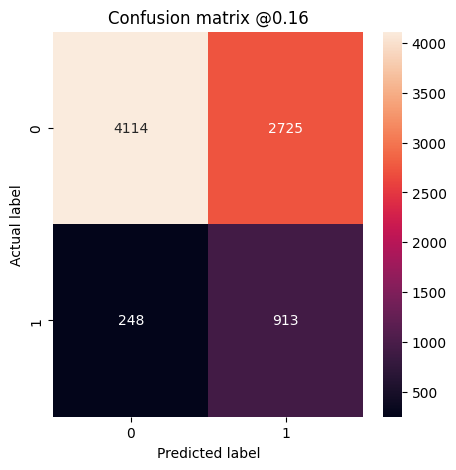

Legitimate TrueClass Detected (True Negatives):  4114
Legitimate TrueClass Incorrectly Detected (False Positives):  2725
Fraudulent TrueClass Missed (False Negatives):  248
Fraudulent TrueClass Detected (True Positives):  913
Total FalseClass:  1161


In [ ]:
y_train_predicted_crossentropy = model_dnn_cross_entropy.predict(X_train_np_arr, batch_size=8024)
y_valid_predicted_crossentropy = model_dnn_cross_entropy.predict(X_valid_np_arr, batch_size=8024)
y_train_predicted_one_class = tf.gather(y_train_predicted_crossentropy, [1], axis=1)
y_train_predicted_one_class

y_valid_predicted_one_class = tf.gather(y_valid_predicted_crossentropy, [1], axis=1)
y_valid_predicted_one_class


plot_cm(y_valid, y_valid_predicted_one_class, 0.5)
plot_cm(y_valid, y_valid_predicted_one_class, 0.16)


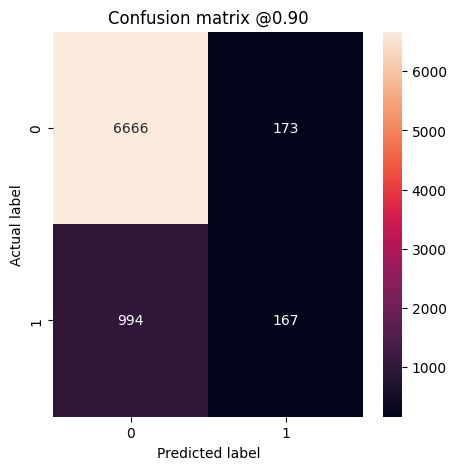

Legitimate TrueClass Detected (True Negatives):  6666
Legitimate TrueClass Incorrectly Detected (False Positives):  173
Fraudulent TrueClass Missed (False Negatives):  994
Fraudulent TrueClass Detected (True Positives):  167
Total FalseClass:  1161


In [ ]:
plot_cm(y_valid, y_valid_predicted_one_class, 0.9)

#### 4.6.1 Final Model : Decision Boundary
- By tweaking the decision boundary we can get higher recall or precision. 
- The optimal decision boundary depends on the business use case. In some cases we want comparatively higher recall e.g telemarketing while in other cases i.e disease detection (hiv), we want comparatively higher precision. We do not want to classify a person as having HIV, when in fact he does not.
- However if we are on general looking for a balance between Sensitivity and Specificity. We can use Roc curves and the  geometric mean.
    

Best Threshold=0.1046157032251358, G-Mean=0.688478459096021


0.1046157

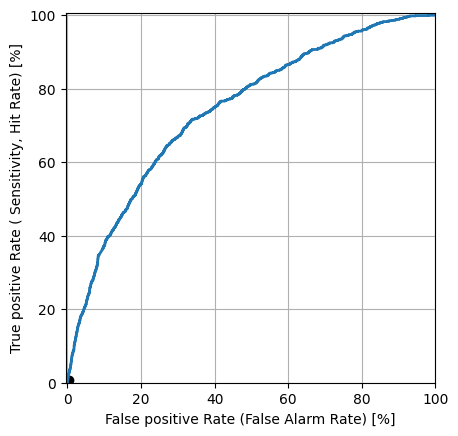

In [ ]:
from numpy import sqrt, argmax

def get_best_threshold_with_best_balance_of_sensitivity_and_specificity(name, labels, predictions, **kwargs):
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)  
  plt.xlabel('False positive Rate (False Alarm Rate) [%]')
  plt.ylabel('True positive Rate ( Sensitivity, Hit Rate) [%]')  
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

  # Geometirc Mean to get optimisd point that has right balance between sensitivity and specificity
  gmeans = sqrt(tpr * (1-fpr))
  # locate the index of the largest g-mean
  ix = argmax(gmeans)
  print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
  return thresholds[ix]


get_best_threshold_with_best_balance_of_sensitivity_and_specificity("Validation Data", y_valid_np_arr, y_valid_predicted_one_class)

#### 4.6.2 Final Model DNN :  Write Prediction
- We will write DNN output for test file to csv now

Restoring model weights from the end of the best epoch: 267.
Epoch 317: early stopping
2/2 [==============================] - 0s 3ms/step
Output File Written at Data/nonglmresults.csv


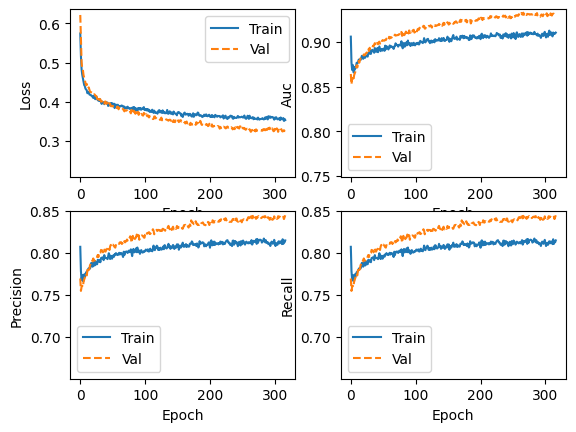

In [ ]:
X_all_np_array = np.array(X_all)
y_all_np_array = np.array(y_all)
y_all_np_arr_cross_entropy = tf.one_hot(y_all_np_array, depth=2)

train_history_cross_entropy_all = model_dnn_cross_entropy.fit(
    X_all_np_array,
    y_all_np_arr_cross_entropy,
    validation_data=(X_valid_np_arr, y_valid_np_arr_cross_entropy),
    batch_size=8024,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=0,
)
test_df_predicted_crossentropy = model_dnn_cross_entropy.predict(test_df, batch_size=8024)
test_df_predicted_one_class = tf.gather(test_df_predicted_crossentropy, [1], axis=1)
write_yes_probability_to_a_file(test_df_predicted_crossentropy, "Data/nonglmresults.csv")
print("Output File Written at Data/nonglmresults.csv")

plot_metrics(train_history_cross_entropy_all, metrics=["loss", "auc", "precision", "recall"])


## 5. Model Comparision : LogisticRegression vs DNN
- We will plot the predicitons from Logistic Regression and DNN and compare them

Text(0.5, 1.0, 'NN - Prediction on TestData')

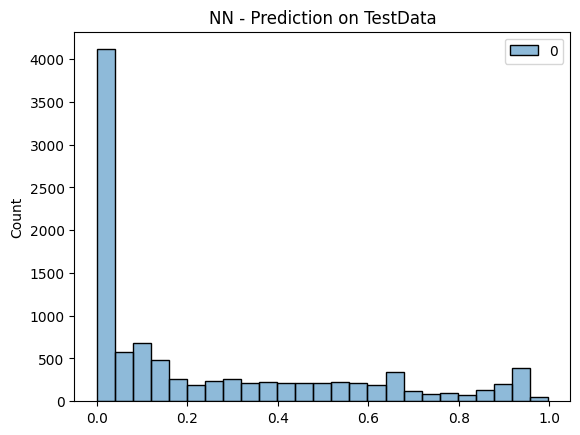

In [ ]:
sns.histplot(test_df_predicted_one_class).set_title("NN - Prediction on TestData")

10000


Text(0.5, 1.0, 'Logistic Regression - Prediction TestData')

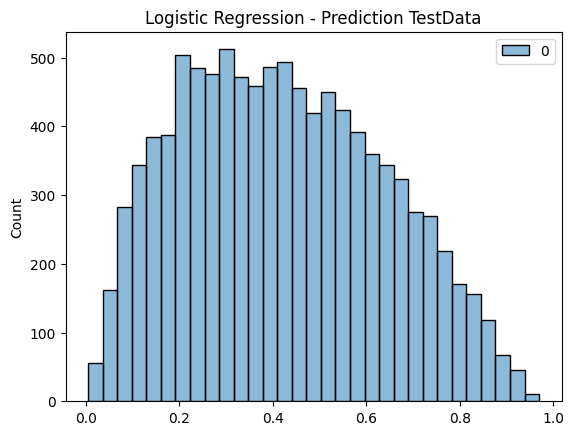

In [ ]:
glmresults = pd.read_csv("Data/glmresults.csv", header=None)
print(len(glmresults))
sns.histplot(glmresults).set_title("Logistic Regression - Prediction TestData")


##  6. Modeling with StatsModel : Logistic Regression Explainable Models
- Logistic Regression from sklearn  is good for prediction  however it is barebone. It provides very few statistical information compared to statsmodel i.e it does not provied p-values for coeficients to tell us coeficient significance and also provided musch richer model statistical information. Hence we will  build a Logistic Regression model with statsmodel library and then use it for further explanation. It provides information i.e p-values for the coeficient, pseudo-R2 values.
- Hence for explainable model purpose, we will modeling with statsmodel with more descriptive statistical properties.

Ref: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit.html




###  6.1 Further Pre-Processing : Multi-colinearity (df-1)
- Transform dummy variable into n-1 variables, because nth variable can be perfectly explained by 1,2,... n-1 variables 
- We will remove the nth variable and during interpretation we will use it as a reference variable to make the explanations.


In [ ]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
import cvxopt


def normalise_column_names(df):
    for col in list(df.columns):
        if col == "y":
            continue

        if "." in col or "-" in col or " " in col:
            # print('Replacing col ', col, col.replace(".","_").replace("-","_"))
            df.rename(columns={col: col.replace(".", "_").replace("-", "_").replace(" ", "_")}, inplace=True)
    return df


def get_df_n_formulae(df, columns, class_label="y"):
    df = df[columns]
    df = normalise_column_names(df)
    normalised_column_names = sorted(list(df.columns))

    if class_label in normalised_column_names:
        normalised_column_names.remove(class_label)

    return df, class_label + " ~ " + " + ".join(normalised_column_names)

# reference_columns_to_remove = ['education_illiterate', 'job_unemployed','month_dec', 'marital_single', 'day_of_week_fri', 'default_miss' ]
reference_columns_to_remove = [
        "x77_toyota",
        "x33_California",
        "x3_Mon",
        "x60_August",
        "x65_allstate"
]
base_explainable_cols = list(train_df.columns)
explainable_cols = list(set(base_explainable_cols) - set(reference_columns_to_remove))

explainable_data_df, explainable_formulae = get_df_n_formulae(train_df, explainable_cols, class_label="y")


logit_model_explainable_variables = logit(explainable_formulae, explainable_data_df).fit_regularized(
    maxiter=100, method="l1", trim_mode="size", size_trim_tol="auto", auto_trim_tol="auto"
)


lr = logit_model_explainable_variables
# marginal_effect = logit_model_explainable_variables.get_margeff()
# marginal_effect.summary()
logit_model_explainable_variables.summary2()




Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3516956441452415
            Iterations: 406
            Function evaluations: 411
            Gradient evaluations: 406


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
===================================================================
Model:                Logit            Pseudo R-squared: 0.151     
Dependent Variable:   y                AIC:              28469.6515
Date:                 2023-02-20 18:14 BIC:              29905.2895
No. Observations:     40000            Log-Likelihood:   -14068.   
Df Model:             166              LL-Null:          -16563.   
Df Residuals:         39833            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       406.0000                                     
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept          -2.2017   0.1394 -15.7948 0.0000 -2.4749 -1.9285
x1                  0.0281   0.0223   1.2618 0.2070 -0.0156  0.0719
x10                 0.0051   0.0194   0.2608 0.7942 -0.0330  0.0431
x100                0.0728   0.0512   1.4229 0.1548 -0.0275  0.1730
x11                 0.1703   0.0404   4.2143 0.0000  0.0911  0.2496
x12                 0.0327   0.0768   0.4264 0.6698 -0.1177  0.1832
x13                 0.0670   0.0372   1.8013 0.0717 -0.0059  0.1398
x14                 0.0399   0.0241   1.6575 0.0974 -0.0073  0.0870
x15                -0.0326   0.0156  -2.0954 0.0361 -0.0631 -0.0021
x16                -0.0308   0.0206  -1.4979 0.1342 -0.0711  0.0095
x17                 0.0138   0.0406   0.3406 0.7334 -0.0658  0.0934
x18                -0.2305   0.0801  -2.8783 0.0040 -0.3875 -0.0735
x19                -0.1956   0.0207  -9.4281 0.0000 -0.2363 -0.1549
x2                  0.0814   0.0806   1.0098 0.3126 -0.0766  0.2393
x20                -0.1245   0.0539  -2.3102 0.0209 -0.2301 -0.0189
x21                 0.0206   0.0153   1.3534 0.1759 -0.0093  0.0505
x22                -0.0007   0.0194  -0.0342 0.9727 -0.0387  0.0374
x23                 0.0113   0.0176   0.6439 0.5196 -0.0231  0.0457
x24                 0.0050   0.0307   0.1622 0.8712 -0.0551  0.0651
x25                 0.0169   0.0215   0.7855 0.4321 -0.0253  0.0591
x26                -0.0024   0.0190  -0.1286 0.8977 -0.0396  0.0348
x27                 0.1197   0.0524   2.2872 0.0222  0.0171  0.2223
x28                -0.3225   0.0718  -4.4922 0.0000 -0.4632 -0.1818
x29                -0.0117   0.0145  -0.8069 0.4197 -0.0402  0.0168
x31                -0.5885   0.0594  -9.9099 0.0000 -0.7049 -0.4721
x32                 0.0069   0.0109   0.6338 0.5262 -0.0144  0.0282
x33_Alabama         0.0929   0.1391   0.6679 0.5042 -0.1798  0.3656
x33_Alaska          1.2433   0.1740   7.1464 0.0000  0.9023  1.5843
x33_Arizona         0.0500   0.1242   0.4023 0.6875 -0.1935  0.2934
x33_Arkansas        0.0527   0.1706   0.3092 0.7572 -0.2816  0.3871
x33_Colorado       -0.2413   0.1485  -1.6250 0.1042 -0.5324  0.0497
x33_Connecticut     0.2186   0.1459   1.4982 0.1341 -0.0674  0.5045
x33_DC              0.4507   0.2082   2.1654 0.0304  0.0428  0.8587
x33_Delaware       -0.2593   0.2514  -1.0313 0.3024 -0.7520  0.2335
x33_Florida         0.5450   0.0795   6.8516 0.0000  0.3891  0.7009
x33_Georgia         0.5682   0.1003   5.6676 0.0000  0.3717  0.7647
x33_Hawaii          0.1890   0.1753   1.0779 0.2811 -0.1546  0.5326
x33_Idaho           1.1944   0.1443   8.2752 0.0000  0.9115  1.4772
x33_Illinois        0.5594   0.0881   6.3506 0.0000  0.3868  0.7321
x33_Indiana         0.3378   0.1153   2.9292 0.0034  0.1118  0.5638
x33_Iowa            0.4386   0.1514   2.8972 0.0038  0.1419  0.7354
x33_Kansas          0.7806   0.1340   5.8271 0.0000  0.5180  1.0431
x33_Kentucky        0.4746   0.1304   3.6392 0.0003  0.2190  0.7302
x33_Louisiana       0.0534   0.1410   0.3786 0.7050 -0.2229  0.3296
x33_Maine           0.3706   0.1833   2.0216 0.0432  0.0113  0.7300
x33_Maryland        0.1058   0.130

### 6.2 LR Model Confusion Matrix : Diff Threshold

In [ ]:
best_lr = logit_model_explainable_variables
print("Confusion Matrix across different threshold")
print(f"\nThreshold=0.5   \n{best_lr.pred_table(0.5)}")
print(f"\nThreshold=0.4   \n{best_lr.pred_table(0.4)}")
print(f"\nThreshold=0.3   \n{best_lr.pred_table(0.3)}")
print(f"\nThreshold=0.2   \n{best_lr.pred_table(0.2)}")
print(f"\nThreshold=0.1   \n{best_lr.pred_table(0.1)}")



Confusion Matrix across different threshold

Threshold=0.5   
[[33775.   422.]
 [ 5167.   636.]]

Threshold=0.4   
[[33109.  1088.]
 [ 4586.  1217.]]

Threshold=0.3   
[[31428.  2769.]
 [ 3722.  2081.]]

Threshold=0.2   
[[27623.  6574.]
 [ 2487.  3316.]]

Threshold=0.1   
[[18480. 15717.]
 [  997.  4806.]]


### 6.3 Future To Dos: Logistic Regression
- Variable slicing for coeficients with larger p-value
- Add in interaction terms